# Skin Cancer template: fork this guy for BT etc

## Install MONAI, updata fastai, any other installs go here

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
pip install fastai==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have 

In [ ]:
#Other installs here

## Imports

In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [4]:
import fastai
from fastai.vision.all import *
#Other imports here
fastai.__version__

'2.7.1'

## Read image filenames from the dataset folders

In [5]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [6]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data

In [29]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num = 100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    #st=extract_text(i.as_posix())
    st=label_func(i)
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
                
#We further partition fnames_train into a tune-valiation set
count_dict2 = {i:0 for i in class_names}
fnames_tune = []
for i in fnames_train:
    st = label_func(i)
    if count_dict2[st] < 0.8*count_dict[st]:
        fnames_tune.append(i)
        count_dict2[st]+=1
        
def get_difference(x1, x2):
    return list(set(x1) - set(x2))

fnames_valid = get_difference(fnames_train,fnames_tune)

fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

#sanity check
def display_dict(_fnames):
    
    _labels = [label_func(i) for i in _fnames]
    tem_dict = {i:_labels.count(i) for i in _labels}
    return tem_dict

tem_dict = display_dict(fnames)
print(f'The "original" training set: \n {tem_dict}\n')

tem_dict = display_dict(fnames_train)
print(f'Training set: used to train BT etc i.e. viewed as unlabelled \n {tem_dict}\n')

print('The training set is partitioned into tune-valid sets, with ~ 80-20 split\n')

tem_dict = display_dict(fnames_tune)
print(f'Tune set: used to train classifiers on representations \n {tem_dict}\n')

tem_dict = display_dict(fnames_valid)
print(f'Valid set: used to validate the classifiers trained above \n {tem_dict}\n')

tem_dict = display_dict(fnames_test)
print(f'Test set: only examine at the very end {tem_dict}\n')

The "original" training set: 
 {'pigmented benign keratosis': 462, 'melanoma': 438, 'vascular lesion': 139, 'actinic keratosis': 114, 'squamous cell carcinoma': 181, 'basal cell carcinoma': 376, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 357}

Training set: used to train BT etc i.e. viewed as unlabelled 
 {'pigmented benign keratosis': 100, 'melanoma': 100, 'vascular lesion': 100, 'actinic keratosis': 100, 'squamous cell carcinoma': 100, 'basal cell carcinoma': 100, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 100}

The training set is partitioned into tune-valid sets, with ~ 80-20 split

Tune set: used to train classifiers on representations 
 {'pigmented benign keratosis': 80, 'melanoma': 80, 'vascular lesion': 80, 'actinic keratosis': 80, 'squamous cell carcinoma': 80, 'basal cell carcinoma': 80, 'seborrheic keratosis': 62, 'dermatofibroma': 76, 'nevus': 80}

Valid set: used to validate the classifiers trained above 
 {'pigmented benign keratosis': 20, 

## Now get the training dataloader and view the data

In [8]:
#get training set
bs=64
item_tfms = [Resize(128)]
dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                    )
x,y = dls_train.one_batch()

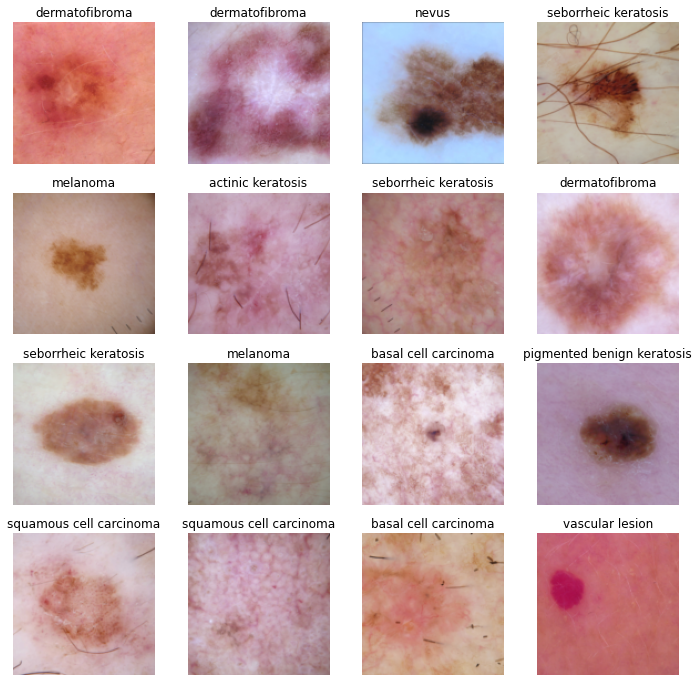

In [9]:
dls_train.show_batch(max_n=16)